### Link to your presentation video here

# Problem Statement
## FIFA 20
Football is arguably the most popular sport in the world and FIFA is the most popular football (soccer) simulation game by Electronic Arts (EA Sports). 

The game is not to be confused with the official International Federation for Football (FIFA).

You are given the following public dataset, scraped from https://sofifa.com. The data lists soccer players from the 2015-2020 editions of EA Sports FIFA video game. It consists of player positions, player attributes and personal data.


## Problem 
The player club changes can be tracked using the unique Sofifa id across all years. The problem statement is as follows: 

## Part A - Rank the Players      
- Who is the best player in the world according to your analysis?
- Use data from FIFA 19. Predict the Overall (OVR ) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19

- Graphically represent the Overall data for the players in test set (see below)

### Instructions : 
- Sofifa Id, URL, Name, Potential, Real face, URL variables cannot be used during the prediction or learning. 

- In case of a change in playing position, alter FIFA 20 position to match FIFA 19 Position 

- The final score will be assigned using MSE. 

- Test Set: Players from the following Clubs 

  - FC Barcelona

  - FC Bayern München

  - Real Madrid 

  - Paris Saint-Germain

  - Juventus

  - Manchester City

  - Liverpool FC

----------------------------------------------------------------------------------------------------------------

### Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('display.max_columns', 100)

### Load the dataset

In [2]:
fifa_19 = pd.read_csv('data/players_19.csv')

# display first 5 rows
fifa_19.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,94,94,77000000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,127100000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Diver, Flair, Long Shot Taker...",84,94,89,81,87,88,...,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,94,94,110500000,565000,"CF, RW, ST",Left,5,4,4,Medium/Medium,Messi,Yes,226500000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",RW,10.0,NaN,2004-07-01,2021.0,CF,10.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (CPU AI Only), S...",77,95,70,90,86,97,...,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,93,118500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,228100000.0,"#Speedster, #Dribbler, #FK Specialist, #Acroba...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Diver, Selfish, Flair, Speed Dribbler (CPU AI ...",79,87,62,84,84,96,...,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,91,93,72000000,260000,GK,Right,4,3,1,Medium/Medium,Lean,Yes,138600000.0,NaN,GK,1.0,NaN,2011-07-01,2019.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,"GK Long Throw, Saves with Feet",17,13,21,50,13,18,...,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,91,92,102000000,355000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,196400000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,N

In [3]:
unique_players = fifa_19.sofifa_id.nunique()
print("Total number of unique players:", unique_players)

Total number of unique players: 17770


# EDA

In [4]:
corr = fifa_19.corr()["overall"].sort_values(ascending=False)

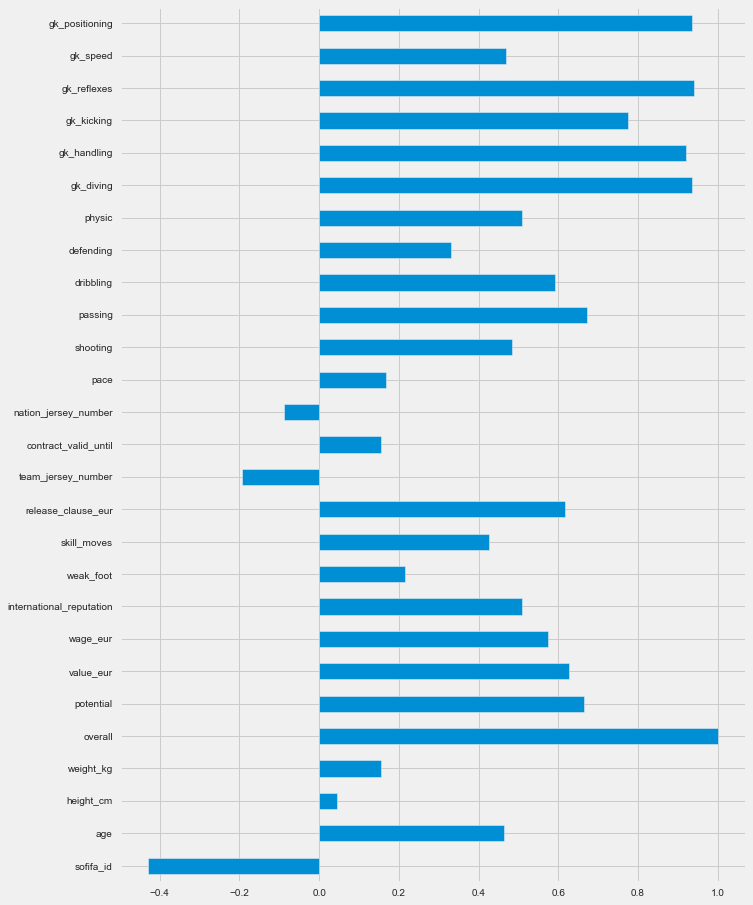

In [17]:
plt.figure(figsize=(10, 15))
fifa_19.corr()['overall'].plot.barh()
plt.show()

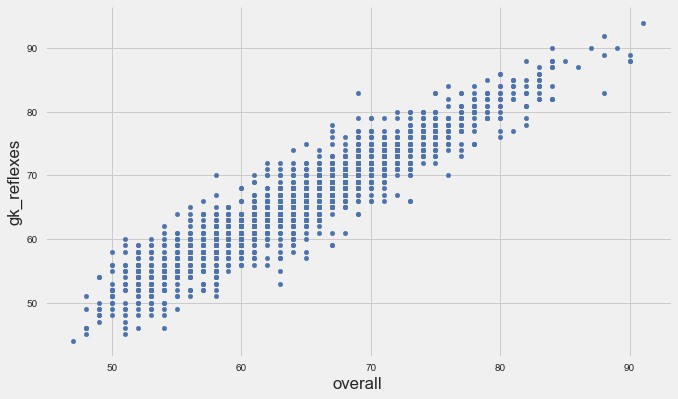

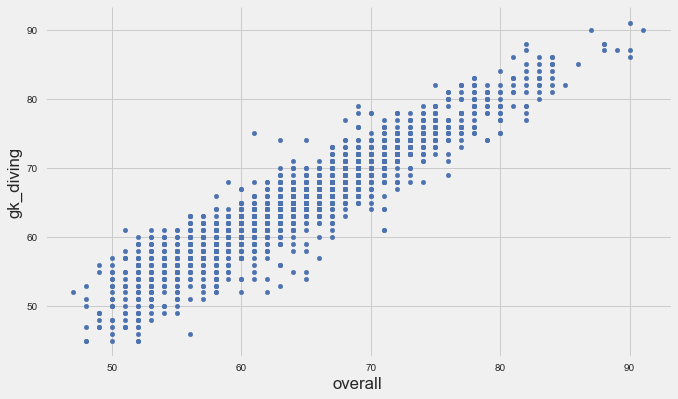

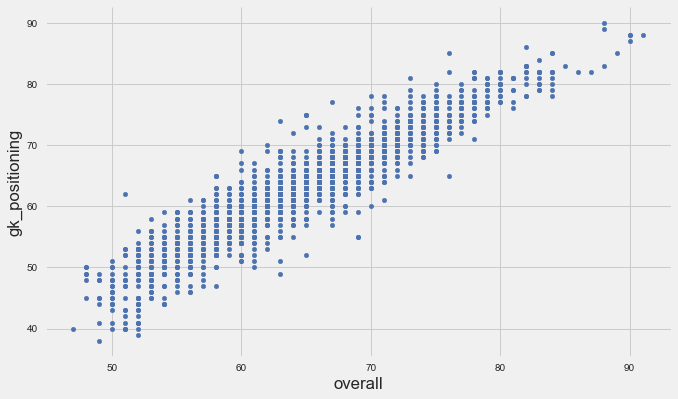

In [16]:
plt.style.use('fivethirtyeight')
for c in corr.index[1:4]:
    ax = fifa_19.plot.scatter('overall', c, figsize=(10, 6))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

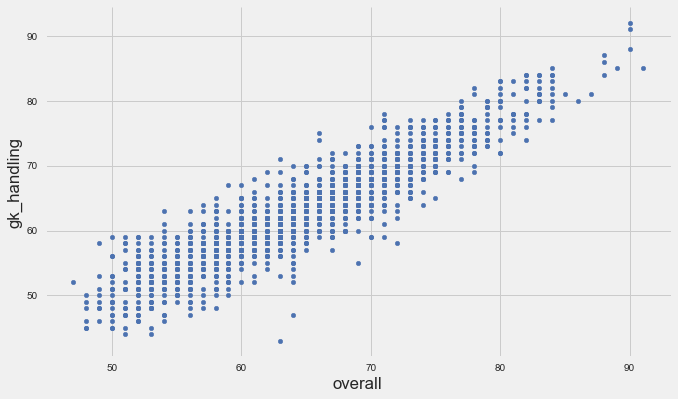

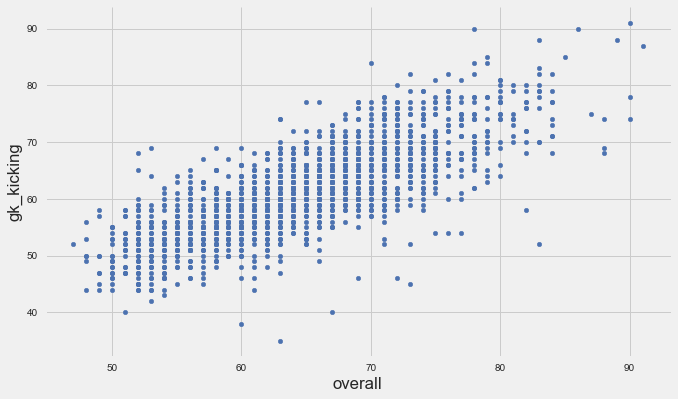

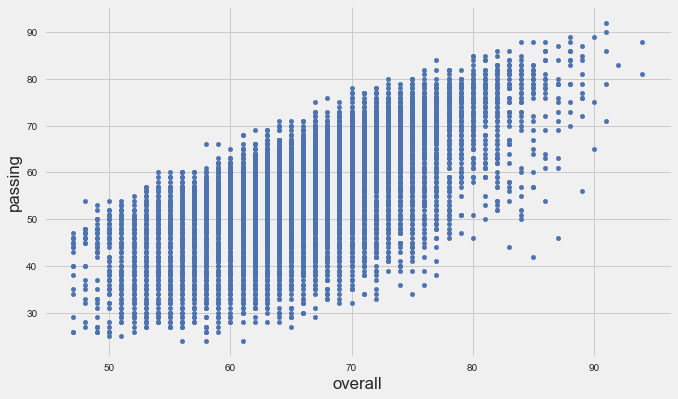

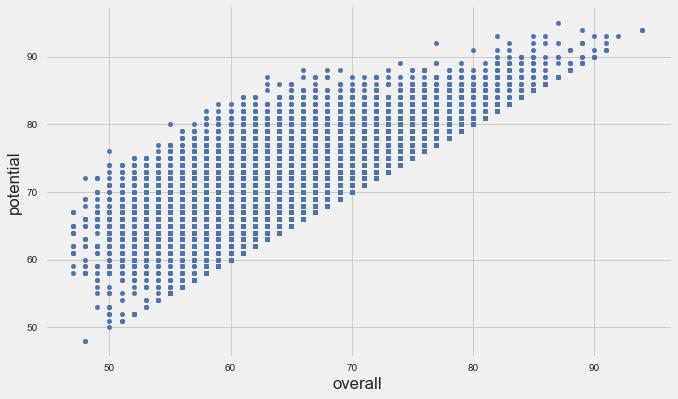

In [18]:
for c in corr.index[4:8]:
    ax = fifa_19.plot.scatter('overall', c, figsize=(10, 6))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

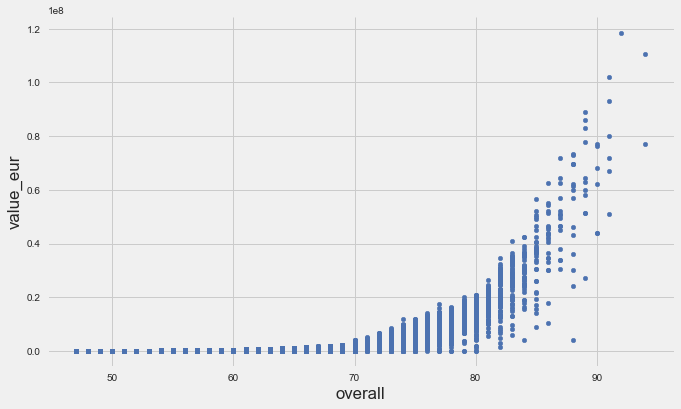

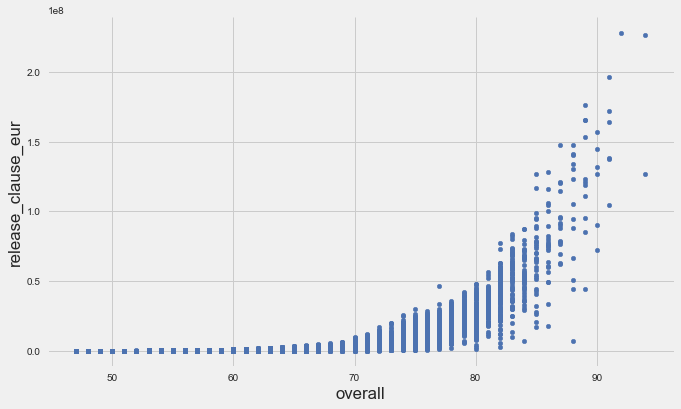

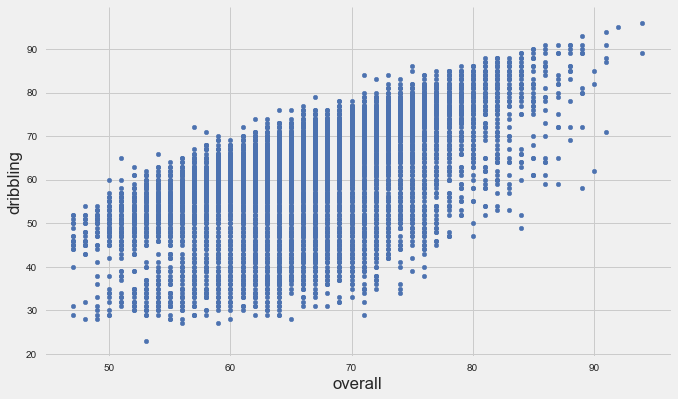

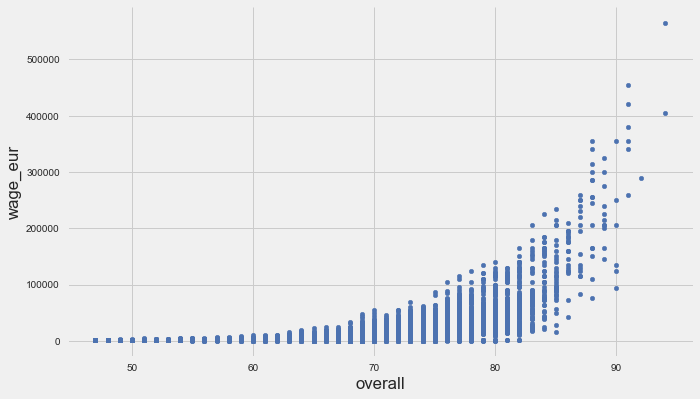

In [19]:
for c in corr.index[8:12]:
    ax = fifa_19.plot.scatter('overall', c, figsize=(10, 6))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

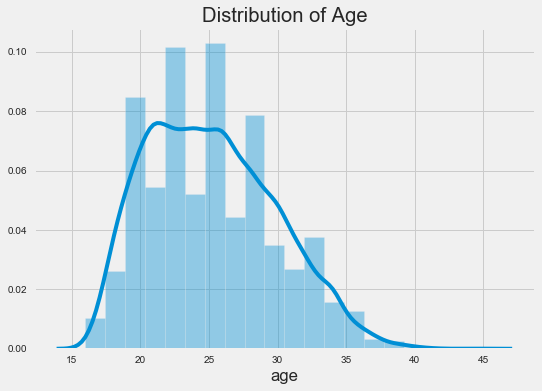

In [20]:
# Distribution of Age
# plt.figure(figsize=(10, 6))
sns.distplot(fifa_19.age, bins=20).set_title("Distribution of Age");

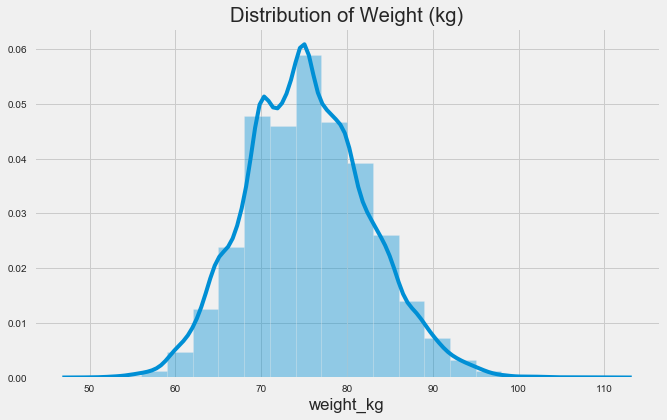

In [21]:
# Distribution of Weight
plt.figure(figsize=(10, 6))
sns.distplot(fifa_19.weight_kg, bins=20).set_title("Distribution of Weight (kg)");

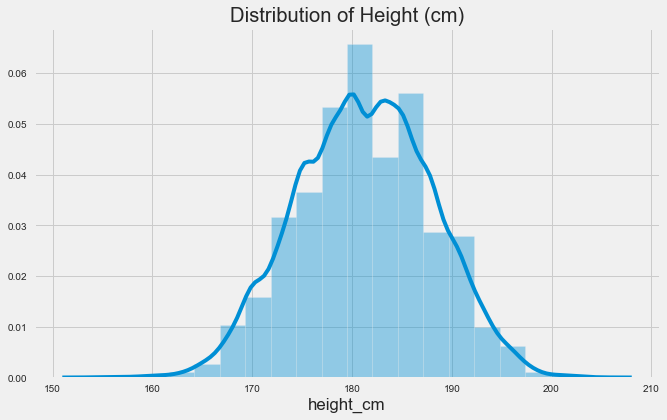

In [22]:
# Distribution of height
plt.figure(figsize=(10, 6))
sns.distplot(fifa_19.height_cm, bins=20).set_title("Distribution of Height (cm)");

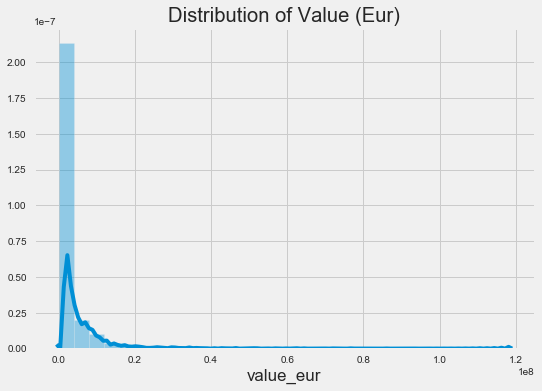

In [24]:
# Distribution of value_eur
sns.distplot(fifa_19.value_eur, bins=30).set_title("Distribution of Value (Eur)");

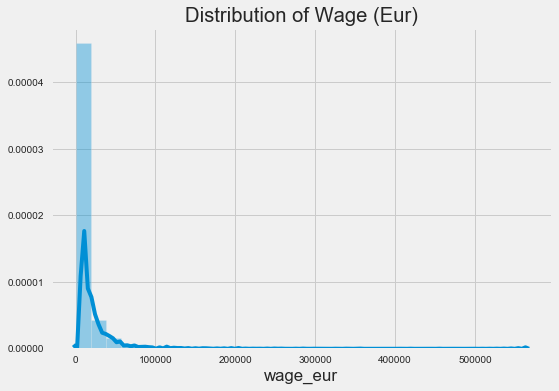

In [25]:
# Distribution of wage
sns.distplot(fifa_19.wage_eur, bins=30).set_title("Distribution of Wage (Eur)");

In [26]:
fifa_19.body_type.value_counts()

Normal                 10410
Lean                    6268
Stocky                  1085
PLAYER_BODY_TYPE_25        1
Shaqiri                    1
Neymar                     1
C. Ronaldo                 1
Messi                      1
Courtois                   1
Akinfenwa                  1
Name: body_type, dtype: int64

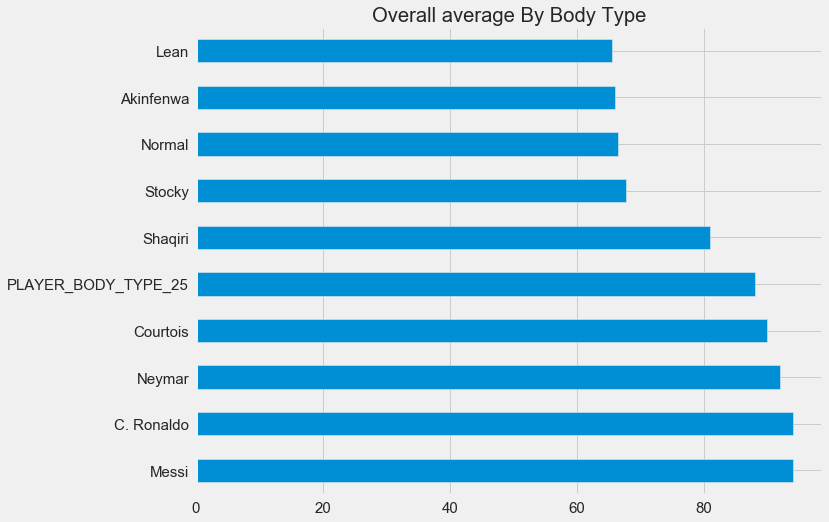

In [35]:
plt.figure(figsize=(10, 8))
ax = fifa_19.groupby('body_type')['overall'].mean().sort_values(ascending=False).plot.barh(fontsize=15)
ax.set_ylabel('')
ax.set_title("Overall average By Body Type")
plt.show()

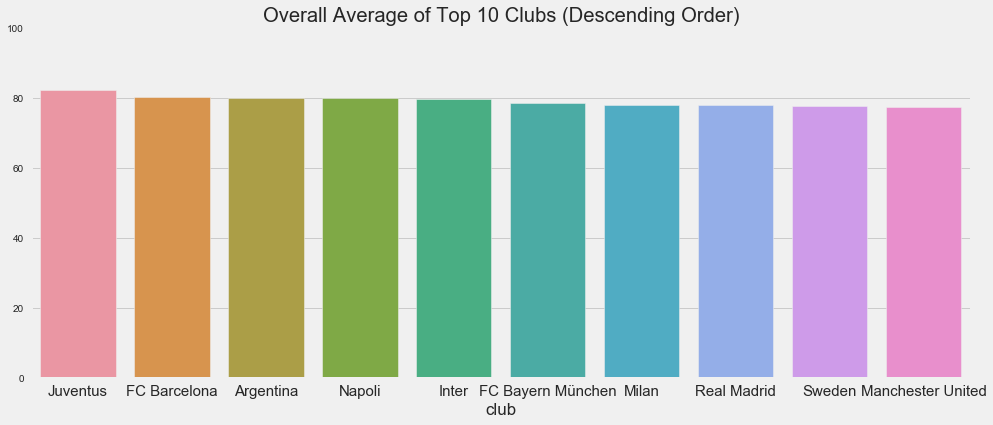

In [44]:
plt.figure(figsize=(15, 6))
sort_by_club = fifa_19.groupby('club')['overall'].mean().sort_values(ascending=False)
sns.barplot(sort_by_club.index[:10], sort_by_club.values[:10])
plt.xticks(fontsize=15)
plt.title("Overall Average of Top 10 Clubs (Descending Order)")
plt.ylim(0, 100)
plt.show()

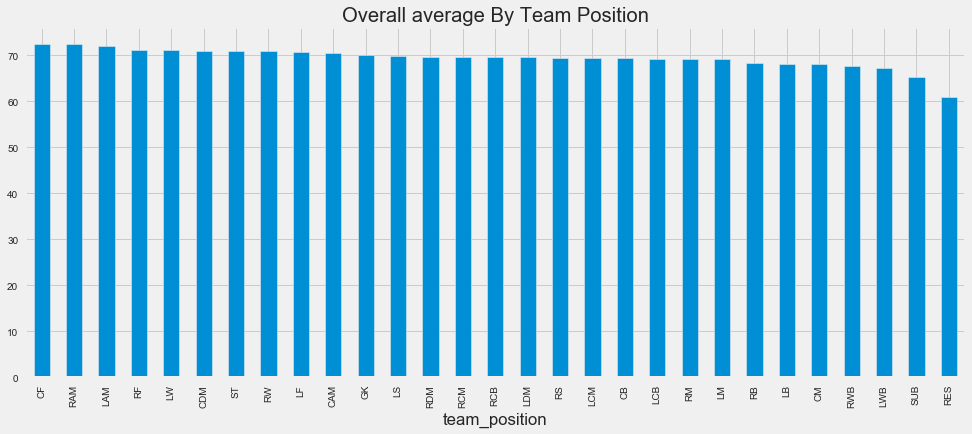

In [46]:
plt.figure(figsize=(15, 6))
ax = fifa_19.groupby('team_position')['overall'].mean().sort_values(ascending=False).plot.bar()
ax.set_title("Overall average By Team Position")
plt.show()

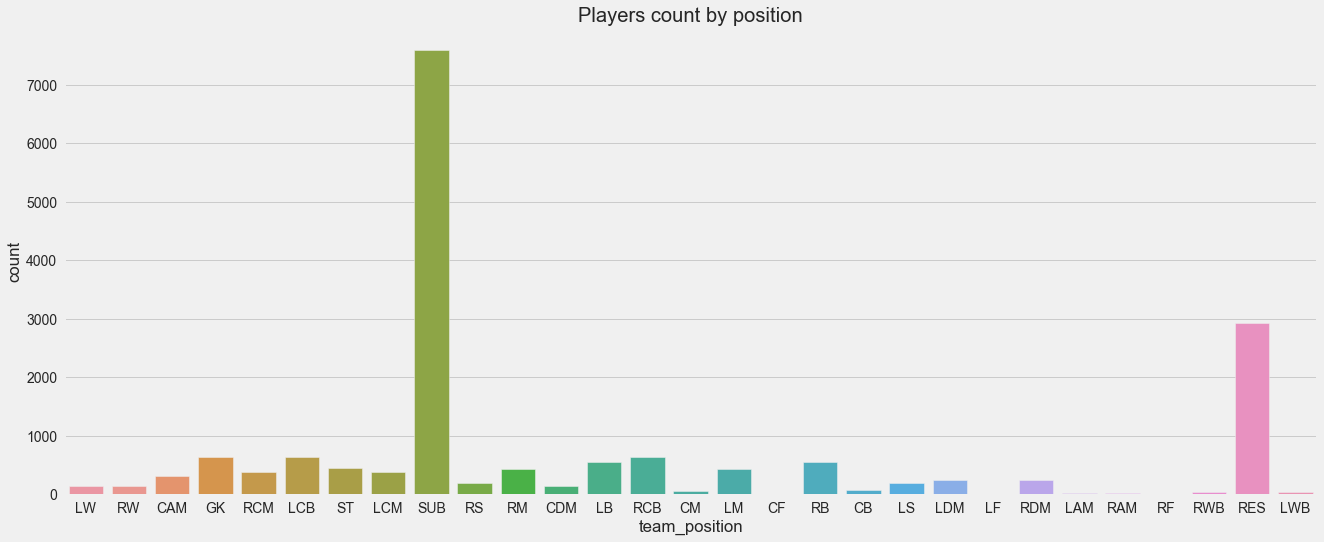

In [52]:
# Let's see the count of players by team position
plt.figure(figsize=(20, 8))
sns.countplot(fifa_19.team_position)
plt.title("Players count by position")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

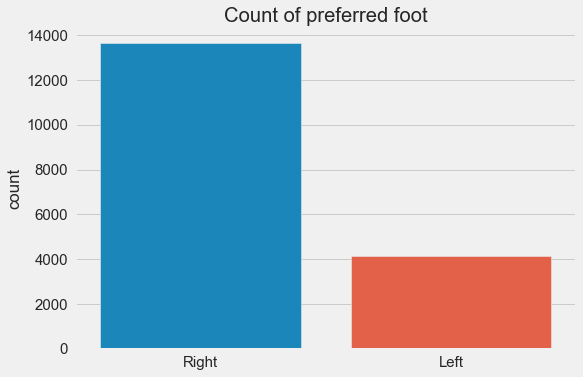

In [56]:
# count number of players by preferred foot
sns.countplot(fifa_19.preferred_foot)
plt.title("Count of preferred foot")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

# Preprocess

In [57]:
from preprocess import preprocess
fifa_19_prerpocessed = preprocess(fifa_19)

In [58]:
fifa_19_prerpocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         17770 non-null  int64  
 1   height_cm                   17770 non-null  int64  
 2   weight_kg                   17770 non-null  int64  
 3   overall                     17770 non-null  int64  
 4   value_eur                   17770 non-null  int64  
 5   wage_eur                    17770 non-null  int64  
 6   preferred_foot              17770 non-null  object 
 7   international_reputation    17770 non-null  int64  
 8   weak_foot                   17770 non-null  int64  
 9   skill_moves                 17770 non-null  int64  
 10  work_rate                   17770 non-null  object 
 11  release_clause_eur          17770 non-null  float64
 12  team_position               17770 non-null  object 
 13  contract_valid_until        177

In [60]:
# OneHotEncode Categorical Variables
fifa_dummies = pd.get_dummies(fifa_19_prerpocessed, drop_first=True)
fifa_dummies.shape

(17770, 120)

## Split into training and testing data

In [ ]:
fifa_final = fifa_dummies.copy()
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_train_sc = scaler.fit_transform(X_train)

# Train different Models

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def display(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())

In [ ]:
# Linear Regression
lreg = LinearRegression()
lin_scores = cross_val_score(lreg, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
display(-lin_scores)

In [ ]:
# KNeighborsRegressor
knn = KNeighborsRegressor()
knn_scores = cross_val_score(knn, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
display(-knn_scores)

In [ ]:
# RandomForerstRegressor
rf = RandomForestRegressor(n_estimators=30)
rf_scores = cross_val_score(rf, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
display(-rf_scores)

In [ ]:
# Train Random Forest on training data and make prediction on test data
rf = RandomForestRegressor(n_estimators=233)
rf.fit(X_train_sc, y_train)
# standarize X_test data
X_test_sc = scaler.transform(X_test)
y_preds = rf.predict(X_test_sc)
test_mse = mean_squared_error(y_test, y_preds)
print("Test MSE:{:.3f}".format(test_mse))

# Training on whole dataset

In [64]:
from sklearn.preprocessing import StandardScaler

fifa_final = fifa_dummies.copy()
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# scale the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=233)
rf.fit(X_scaled, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=233, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [65]:
import joblib

# saving the trained model
joblib.dump(rf,'best_rf.h5')

['best_rf.h5']

## Predict on 2020 Fifa Dataset

In [66]:
fifa_2020 = pd.read_csv('data/players_20.csv')

# filter out the clubs which will be used for prediction
clubs = ['FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Manchester City', 'Liverpool FC']
# preprocess the data
fifa_20_cleaned = preprocess(fifa_2020, True)
# assign categorical columns to be one hot encoded
OneHotCols = ['preferred_foot', 'work_rate', 'team_position']
# OneHotEncode categorical columns
final_dummies = pd.get_dummies(fifa_20_cleaned, columns=OneHotCols, drop_first=True)
# only keep necessary rows
def func(se):
    if se in clubs:
        return True
    return False 

final_dummies['mask'] = final_dummies.club.apply(func)
final_test = final_dummies[final_dummies['mask']]

In [67]:
# separate predictor and response
X_test = final_test.drop(['overall', 'club', 'mask', 'short_name'], axis=1)
y_test = final_test.overall

# scale the X_test
X_test_scaled = scaler.transform(X_test)

In [70]:
from sklearn.metrics import mean_squared_error

# make prediction using the trained model
final_preds = rf.predict(X_test_scaled)
# print mean squared error
print("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, final_preds)))

Mean Squared Error: 0.566


In [75]:
# Create a dataframe using necessary columns that will be used for visualizaiton
df = final_test[['club', 'overall', 'short_name']].copy()
# # add prediction to the dataframe
df['prediction'] = final_preds
# # sort the datafame in descending order by predictions
df_sorted = df.sort_values(by='prediction', ascending=False)
# # print first five rows
df.head()

,club,overall,short_name,prediction
0,FC Barcelona,94,L. Messi,92.811159
1,Juventus,93,Cristiano Ronaldo,91.463519
2,Paris Saint-Germain,92,Neymar Jr,91.240343
4,Real Madrid,91,E. Hazard,91.025751
5,Manchester City,91,K. De Bruyne,90.673820


In [77]:
# get top 10 predicted scores
top_10_predictions = df_sorted.iloc[:10, 3].values
# get first 10 actual scores 
actual = df_sorted.iloc[:10, 1].values
# get the names of the first 10 players
top_10_players = df_sorted.iloc[:10, 2].values

In [144]:
actual

array([94, 93, 92, 91, 91, 89, 90, 89, 89, 90], dtype=int64)

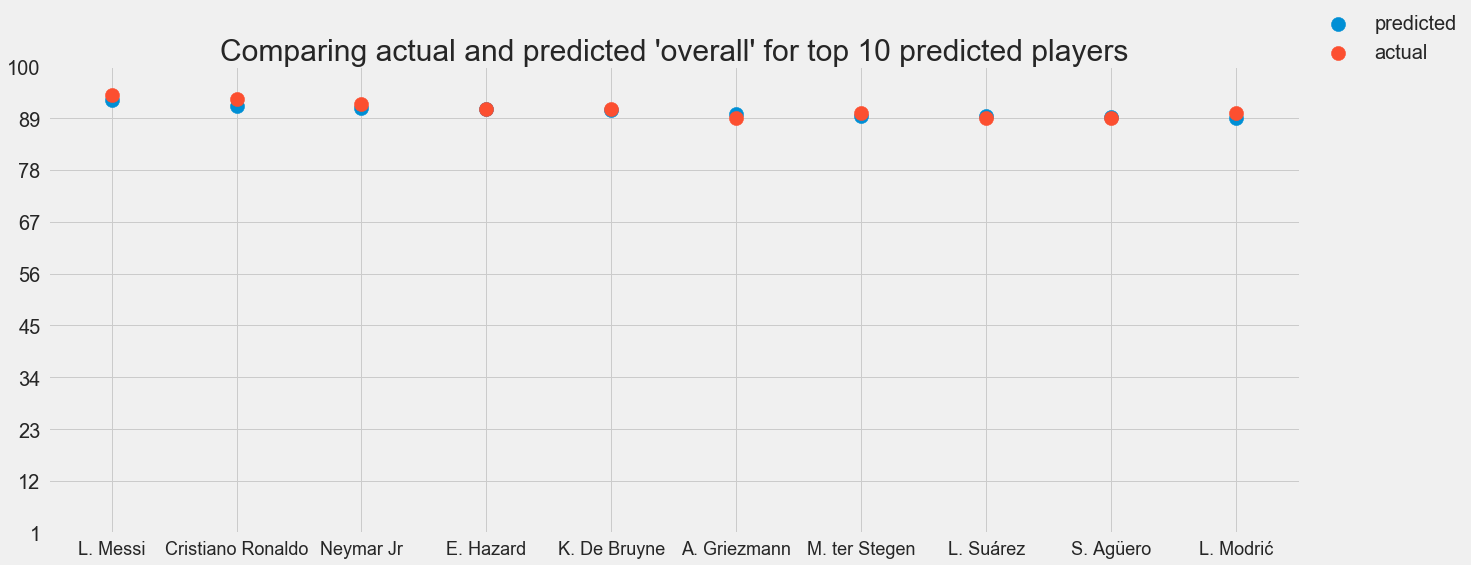

In [164]:
# create xticks for side-by-side bar plot
xticks1 = np.arange(10)
xticks2 = xticks1+0.4

plt.style.use('fivethirtyeight')
# plot
plt.figure(figsize=(20, 8))
plt.scatter(xticks1, top_10_predictions, label="predicted", s=200)
plt.scatter(xticks1, actual, label="actual", s=200)
plt.xticks(xticks1, top_10_players, fontsize=18)
plt.yticks(np.linspace(1, 100, 10), fontsize=20)
plt.title("Comparing actual and predicted 'overall' for top 10 predicted players", fontsize=30)
plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.show()

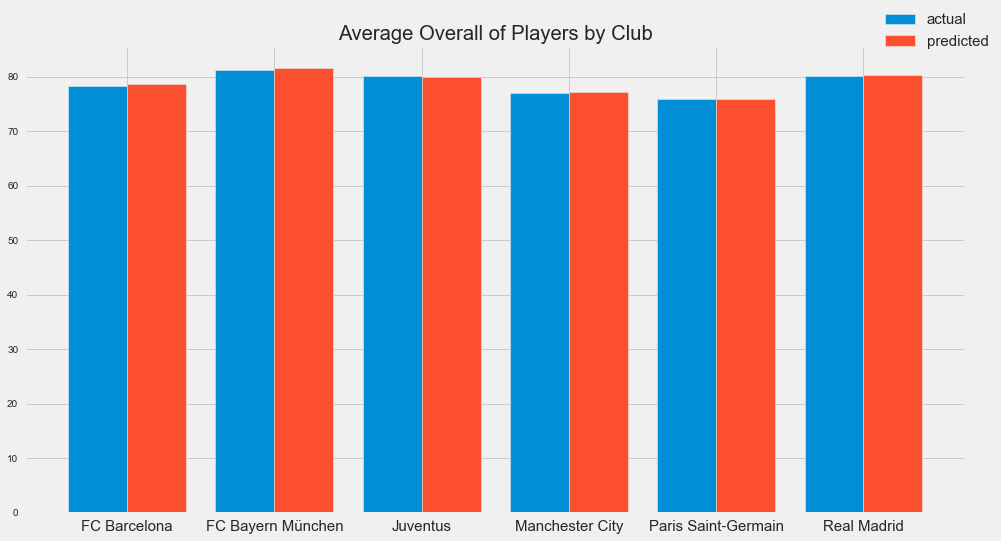

In [162]:
ax = df.groupby('club')['overall'].mean()
ax1 = df.groupby('club')['prediction'].mean()
# plot
plt.figure(figsize=(15, 8))
plt.bar([1, 1.5, 2, 2.5, 3, 3.5], ax.values, width=0.2, label="actual")
plt.bar([1.2, 1.7, 2.2, 2.7, 3.2, 3.7], ax1.values, width=0.2, label="predicted")
plt.xticks([1.1, 1.6, 2.1, 2.6, 3.1, 3.6], labels=list(ax.index), fontsize=15)
plt.title("Average Overall of Players by Club")
plt.legend(bbox_to_anchor=(0.9, 1.1), loc='upper left', fontsize=15)
plt.show()

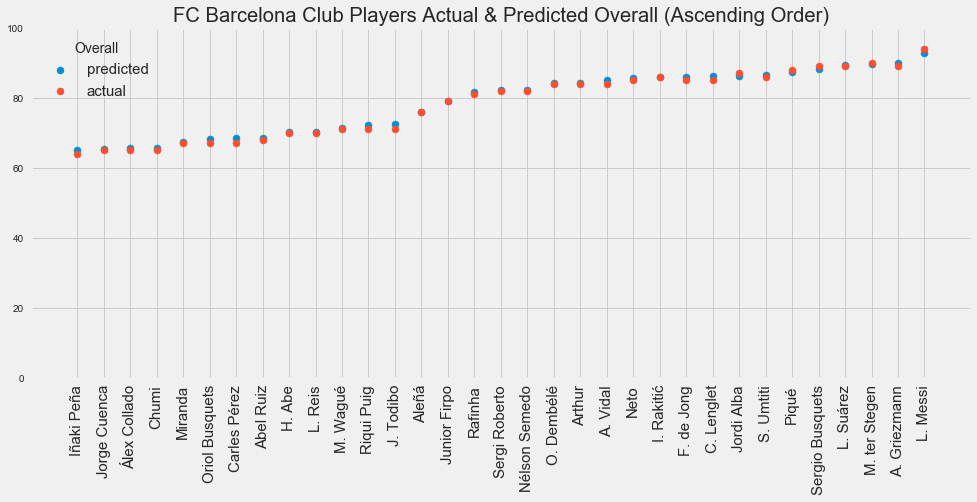

In [210]:
# plot barcelona's players overall
barca = df[df['club'] == 'FC Barcelona']
barca = barca.sort_values(by='prediction')
# plot
xticks = np.arange(len(barca))
plt.figure(figsize=(15, 6))
plt.scatter(xticks, barca.prediction, label='predicted')
plt.scatter(xticks, barca.overall, label='actual')
plt.ylim(0, 100)
plt.xticks(ticks=xticks, fontsize=15, rotation=90, labels=barca.short_name)
plt.legend(title='Overall', loc='upper left', fontsize=15)
plt.title("FC Barcelona Club Players Actual & Predicted Overall (Ascending Order)")
plt.show()

# ==============================================================

# Hyper-parameter Tuning
## We can see that the Ranfom Forest performed way better than the other two, we can tune Random Forest for more better results

**Note:** This code can take more than 30 mins to execute

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_sc, y_train)

In [ ]:
best_rf = rf_random.best_estimator_
# RandomForerstRegressor
# rf = RandomForestRegressor(n_estimators=30)
rf_scores = cross_val_score(best_rf, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
display(-rf_scores)

In [ ]:
best_rf = rf_random.best_estimator_
# RandomForerstRegressor
# rf = RandomForestRegressor(n_estimators=30)
rf_scores = cross_val_score(best_rf, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
display(-rf_scores)

In [ ]:
rf_random.best_estimator_

In [ ]:
import joblib
best_rf.fit(X_train_sc, y_train)
joblib.dump(best_rf, 'best_model.h5')